# Temporal GFP

In [1]:
import pandas as pd
import numpy as np
import math
import networkx as nx
import statsmodels.api as sm
from datetime import datetime
import sqlite3
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from itertools import combinations

import warnings
warnings.filterwarnings("ignore")

from utils import *

In [2]:
# dfall = pd.DataFrame()
# for y in range(2012, 2016):  # will change to (2012, 2016 later)
#     dfyear = build_df_year(y, with_text=False, with_time=True, filter_null=True)
#     dfall = dfall.append(dfyear)

## filter data

In [3]:
# user_select = pd.read_csv(ROOTPATH + "indx/ACTIVEUSERS_ALLYEARS_1_2_50.csv")
# USERS = user_select["author"].tolist()
# dfall = dfall[dfall["author"].isin(USERS)]

# # generate user index
# user2index = index2user = {}
# for i,u in enumerate(USERS):
#     user2index[u] = i
#     index2user[i] = u

## build temporal dataframe

In [4]:
# aggr_func = {"author": lambda x: set(x)}
# groupby_subm = dfall[["submission_id","author"]].groupby("submission_id").agg(aggr_func).reset_index()
# SUBM_USERSET = groupby_subm.set_index("submission_id").to_dict()["author"]

# # later only focus on multi-user submissions
# groupby_subm["n_author"] = groupby_subm["author"].map(lambda x: len(x))
# SU_SUBM = groupby_subm[groupby_subm["n_author"]==1]["submission_id"].tolist()
# df_multiuser_subm = dfall[~dfall["submission_id"].isin(SU_SUBM)]

In [5]:
# start and end time of submissions
# aggr_func = {"created_utc": [np.min, np.max]}
# SUBM_TIME = dfall[["submission_id","created_utc"]].groupby("submission_id").agg(aggr_func)
# SUBM_TIME.columns = SUBM_TIME.columns.droplevel(0)
# SUBM_TIME_DICT = SUBM_TIME.to_dict()

In [6]:
# TOX_DF = dfall[["author","created_utc","toxicity"]].sort_values(by=["author", "created_utc"])
# TOX_DF = TOX_DF.reset_index().drop(columns=["index"])
# aggr_func = {"created_utc":lambda x: list(x), "toxicity":lambda x: list(x)}
# TOX_DF_AGGR = TOX_DF.groupby("author").agg(aggr_func)
# TOX_DICT = TOX_DF_AGGR.to_dict()

In [7]:
def calculate_temp_toxicity(user, start, end):
    times = TOX_DICT["created_utc"][user]
    scores = TOX_DICT["toxicity"][user]
    tox_ls = []
    for (t,s) in zip(times, scores):
        if t>=start and t<=end and str(s)!="nan":
            tox_ls.append(s)
    return np.mean(tox_ls)

In [9]:
# dfall["uniq_id"] = range(0, len(dfall))
# dfall = dfall.sort_values(by=["author", "created_utc"])
# UNIQ2TIME = dfall[["uniq_id", "created_utc"]].set_index("uniq_id").to_dict()["created_utc"]

In [11]:
# aggr_func = {"uniq_id": lambda x: list(x)}
# groupby_user = dfall[["uniq_id","author"]].groupby("author").agg(aggr_func)
# USER_POST_DICT = groupby_user.to_dict()["uniq_id"]
# uniq2subm = dfall[["uniq_id","submission_id"]].set_index("uniq_id").to_dict()["submission_id"]

## examine temporal TFP

In [12]:
# step = 0.1
# temp_me_tox = np.zeros((len(USERS), int(1/step)))
# temp_env_tox = np.zeros((len(USERS), int(1/step)))
# temp_gfp = np.zeros((len(USERS), int(1/step)))

# for j, (u, all_posts) in enumerate(USER_POST_DICT.items()):
#     if j%10==0: print("progress:", j/len(USERS))
# #     print("user:", j, u)
#     for i in range(int(1/step)):
        
# #         print("computing window...")
#         post_window = all_posts[math.floor(step*i*len(all_posts)):math.floor(step*(i+1)*len(all_posts))]
#         subm_window = list(set([uniq2subm[x] for x in post_window]))
#         start_time = SUBM_TIME_DICT["amin"][subm_window[0]]
#         end_time = UNIQ2TIME[post_window[-1]]
        
# #         print("getting neighbors...")
#         temp_neighbors = []
#         for subm in subm_window:
#             temp_neighbors += SUBM_USERSET[subm]
#         temp_neighbors = set(temp_neighbors)

# #         print("calculating toxicity...")
#         my_tox = calculate_temp_toxicity(u, start_time, end_time)
#         env_tox = []
#         for nei in temp_neighbors:
#             their_tox = calculate_temp_toxicity(nei, start_time, end_time)
#             if str(their_tox)!="nan":
#                 env_tox.append(their_tox)
#         env_tox = np.mean(env_tox)
        
#         temp_me_tox[user2index[u],i] = my_tox
#         temp_env_tox[user2index[u],i] = env_tox
#         if env_tox > my_tox:
#             temp_gfp[user2index[u],i] = 1  

In [13]:
# uncomment if reading from saved matrices
temp_me_tox = np.load(ROOTPATH + "output/matrix/temp_me_tox.dat", allow_pickle=True)
temp_env_tox = np.load(ROOTPATH + "output/matrix/temp_env_tox.dat", allow_pickle=True)
temp_gfp = np.load(ROOTPATH + "output/matrix/temp_gfp.dat", allow_pickle=True)

In [14]:
temp_tox_diff = temp_env_tox - temp_me_tox

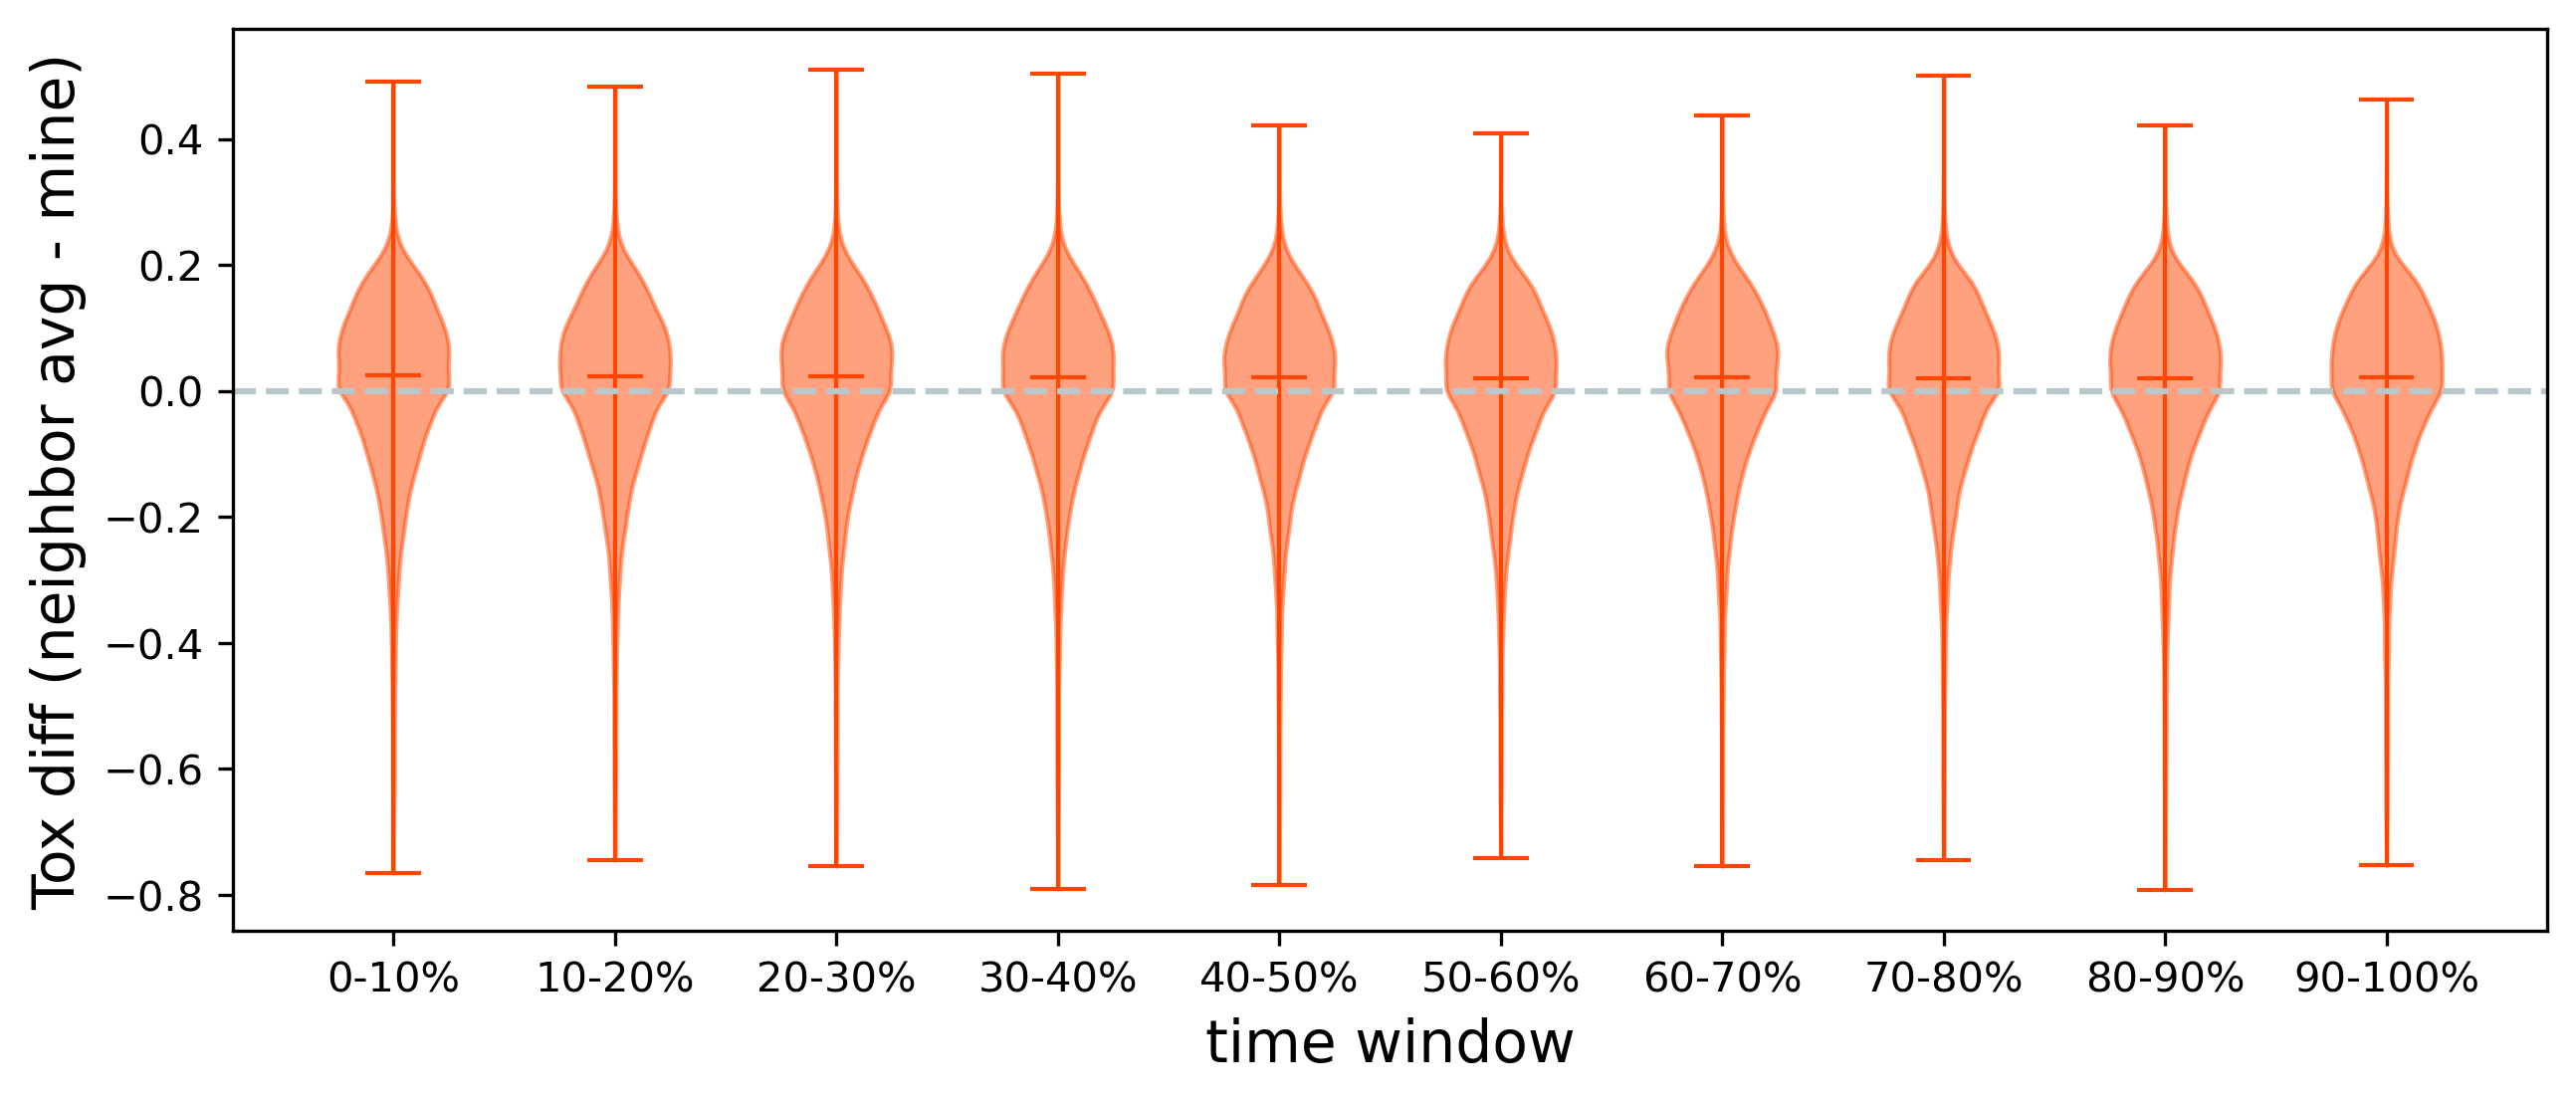

In [72]:
fig,ax = plt.subplots(figsize=(10,4), dpi=300)
data = []
data_medians = []
for i in range(10):
    diffs = temp_tox_diff.T[i]
    diffs = [x for x in diffs if str(x) != "nan"]
    data.append(diffs)
    data_medians.append(np.median(diffs))
vps = ax.violinplot(data, showmeans=False, showmedians=True, showextrema=True)
# plt.plot(np.arange(1,11), data_medians, marker="^", color="#0079D3", markersize=10)
plt.axhline(y=0, color="#B8C7CC", linestyle="--")
for part in ("cbars", "cmins", "cmaxes", "cmedians"):
    vp = vps[part]
    vp.set_edgecolor("#FF4500")
    vp.set_linewidth(1)
    
for vp in vps["bodies"]:
    vp.set_edgecolor("#FF4500")
    vp.set_facecolor("#FF4500")
    vp.set_linewidth(1)
    vp.set_alpha(0.5)
plt.xticks(np.arange(1,11),[f"{x-10}-{x}%" for x in np.arange(10,110,10)])
plt.xlabel("time window", fontsize=14)
plt.ylabel("Tox diff (neighbor avg - mine)", fontsize=14)
plt.savefig(ROOTPATH + "output/fig/temporal_tfp.png", dpi=300)